In [1]:
import numpy as np
import dynesty
from dynesty import NestedSampler
from dynesty import utils as dyfunc
import matplotlib.pyplot as plt
import corner
from dynesty import DynamicNestedSampler


In [3]:

from scipy.special import logsumexp

# Prior cube: [-L, L]^D 
L = 6.0
ndim = 20
prior_volume = (2*L)**ndim

# Parameters of the twin shells (from paper)
w1 = w2 = 0.1  # thickness of both shells
r1 = r2 = 2.0  # radius of both shells
c1 = np.array([-3.5] + [0.0] * (ndim - 1))  # center of first shell
c2 = np.array([3.5] + [0.0] * (ndim - 1))   # center of second shell

def logprior(theta):
    """Uniform prior over [-L, L]^D."""
    if np.all(np.abs(theta) <= L):
        return -np.log(prior_volume)
    else:
        return -np.inf

def loglikelihood(theta):
    """
    Twin Gaussian shell log-likelihood from equation (38) in the paper.
    L(θ) = (1/√(2πw₁)) * exp[-(|θ-c₁|-r₁)²/(2w₁²)] + (1/√(2πw₂)) * exp[-(|θ-c₂|-r₂)²/(2w₂²)]
    """
    # Distance from centers
    r_c1 = np.linalg.norm(theta - c1)
    r_c2 = np.linalg.norm(theta - c2)
    
    # Log-likelihood components for each shell
    # Note: We work in log space for numerical stability
    log_norm1 = -0.5 * np.log(2 * np.pi * w1**2)
    log_norm2 = -0.5 * np.log(2 * np.pi * w2**2)
    
    log_exp1 = log_norm1 - 0.5 * ((r_c1 - r1) / w1)**2
    log_exp2 = log_norm2 - 0.5 * ((r_c2 - r2) / w2)**2
    
    # Use logsumexp for numerical stability when adding exponentials
    return logsumexp([log_exp1, log_exp2])

def prior_transform(u):
    """
    Map unit cube [0,1]^D to [-L, L]^D.
    u: array in [0,1]^D
    """
    return -L + 2*L*u

# Optional: Visualization function for 2D case
def plot_twin_shells_2d():
    """Plot the twin Gaussian shells for visualization (2D only)."""
    if ndim != 2:
        print("Visualization only available for 2D case")
        return
    
    # Create grid
    x = np.linspace(-6, 6, 200)
    y = np.linspace(-6, 6, 200)
    X, Y = np.meshgrid(x, y)
    
    # Evaluate likelihood on grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            theta = np.array([X[i,j], Y[i,j]])
            Z[i,j] = np.exp(loglikelihood(theta))
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(label='Likelihood')
    plt.xlabel('θ₁')
    plt.ylabel('θ₂')
    plt.title('Twin Gaussian Shells')
    
    # Mark centers
    plt.plot(c1[0], c1[1], 'r*', markersize=15, label='Center 1')
    plt.plot(c2[0], c2[1], 'r*', markersize=15, label='Center 2')
    
    # Draw circles showing the shell radii
    circle1 = plt.Circle(c1[:2], r1, fill=False, color='red', linestyle='--', alpha=0.7)
    circle2 = plt.Circle(c2[:2], r2, fill=False, color='red', linestyle='--', alpha=0.7)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    
    plt.legend()
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage with dynesty
def run_dynesty_example():
    """Example of how to use this with dynesty."""
    try:
        import dynesty
        from dynesty import plotting as dyplot
        
        # Run nested sampling
        sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim)
        sampler.run_nested()
        results = sampler.results
        
        print(f"Log evidence: {results.logz[-1]:.2f} ± {results.logzerr[-1]:.2f}")
        
        # Plot results
        fig, axes = dyplot.runplot(results)
        plt.show()
        
        return results
        
    except ImportError:
        print("Dynesty not installed. Install with: pip install dynesty")
        return None

# Analytical log-evidence values from the paper (for reference)
analytical_logz = {
    20: -36.09, # 20D case from paper
    30: -60.13  # 30D case from paper
}



if __name__ == "__main__":
    print(f"Twin Gaussian Shell Problem Setup:")
    print(f"Dimensions: {ndim}")
    print(f"Prior bounds: [{-L}, {L}]^{ndim}")
    print(f"Shell centers: c1={c1}, c2={c2}")
    print(f"Shell radii: r1={r1}, r2={r2}")
    print(f"Shell widths: w1={w1}, w2={w2}")
    
    if ndim == 2:
        print("\nGenerating 2D visualization...")
        plot_twin_shells_2d()
    
    # Uncomment to run dynesty example
    # results = run_dynesty_example()


# -------------------------------
# Run dynesty Nested Sampling
# -------------------------------
NN = 1

log_z_NS = np.zeros(NN)
log_z_NS_err = np.zeros(NN)

for i in range(NN):
# Set up the sampler
    # sampler = NestedSampler(
    #     loglikelihood,
    #     prior_transform,
    #     ndim,
    #     nlive=5000,      # number of live points; increase for accuracy
    #     sample="rwalk",  # random-walk proposals; can try "unif", "slice"
    #     bound="multi",   # bounding method ("multi" good for multimodal)
    # )
    sampler = DynamicNestedSampler(
        loglikelihood,
        prior_transform,
        ndim,
        nlive=4000,
        )

    print("Running dynesty Nested Sampling on Gaussian shell...")
    sampler.run_nested(dlogz_init=0.1,print_progress=True)
    res = sampler.results
    samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
    posterior_samples = dyfunc.resample_equal(samples, weights)
    # -------------------------------
    # Report results
    # -------------------------------
    log_z_NS[i] = res.logz[-1]
    log_z_NS_err[i] = res.logzerr[-1]
true_logz = -36.09
print("\n==== RESULTS ====")
print(f"dynesty estimated logZ = {log_z_NS.mean():.3f} ± {log_z_NS_err.mean():.3f}")
print(f"True logZ (literature) = {true_logz:.3f}")
print(f"Error = {log_z_NS.mean()- true_logz:.3f}")


Twin Gaussian Shell Problem Setup:
Dimensions: 20
Prior bounds: [-6.0, 6.0]^20
Shell centers: c1=[-3.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0. ], c2=[3.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
Shell radii: r1=2.0, r2=2.0
Shell widths: w1=0.1, w2=0.1
Running dynesty Nested Sampling on Gaussian shell...


0it [00:00, ?it/s]

162932it [08:44, 310.58it/s, batch: 0 | bound: 242 | nc: 1 | ncall: 5929843 | eff(%):  2.748 | loglstar:   -inf <  1.384 <    inf | logz: -35.993 +/-  0.095 | dlogz:  0.000 >  0.100]      



==== RESULTS ====
dynesty estimated logZ = -35.993 ± 0.125
True logZ (literature) = -36.090
Error = 0.097


Selected pair: param_0, param_1 (MI=0.1183)
Pairs selected (1): [('param_0', 'param_1', 0.11825338311479032)]
Singles (0): []


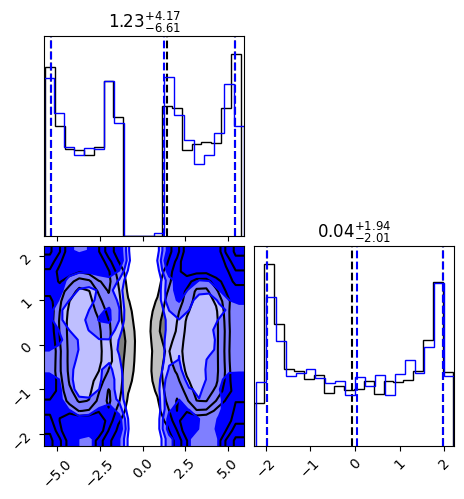

In [ ]:
pair_kde = morphZ.PairwiseKDE(samples,'/home/apokrypha/Local NT/paper_tests_morph/morphZ_gaussian_shell/params_MI.json',bw=0.02,verbose=True)
pair_samples = pair_kde.resample(2000)
indep_kde = morphZ.KDE_approx(posterior_samples,bw=0.02)
indep_samples = indep_kde.resample(2000)
fig = corner.corner(
    posterior_samples[::10,:5], bins=20,label_kwargs = {"fontsize": 7},truth_color="dodgerblue",hist_kwargs={"density": True},quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    fontzise=6,
    title_fmt=".2f",
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.5, 0.8, 0.95),         
    smooth=1.0  
)
corner.corner(
    pair_samples[:,:5],color="red", bins=20,label_kwargs = {"fontsize": 7},truth_color="dodgerblue",hist_kwargs={"density": True},quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    fig=fig,
    fontzise=6,
    title_fmt=".2f",
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.5, 0.8, 0.95),         
    smooth=1.0  
)
corner.corner(
    indep_samples[:,:5],color="blue", bins=20,label_kwargs = {"fontsize": 7},truth_color="dodgerblue",hist_kwargs={"density": True},quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    fig=fig,
    fontzise=6,
    title_fmt=".2f",
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.5, 0.8, 0.95),         
    smooth=1.0  
)
plt.show()

In [4]:
import morphZ

    
def lnprobfn(theta):
    """Log-probability combining prior and likelihood."""
    return logprior(theta) + loglikelihood(theta)

In [11]:
samples = posterior_samples[::70,:]  # total_samples[::20,:]
tot_len , ndim = samples.shape
print('Total samples:', tot_len, 'Dimensions:', ndim)
log_prob = np.zeros(tot_len)

for i in range(tot_len):
    log_prob[i] = lnprobfn(samples[i,:])

log_p_estimate = morphZ.evidence(
samples,
log_prob,
lnprobfn,
n_resamples=1000,
thin=1,n_estimations=5,kde_type="3_group",output_path='./morphZ_gaussian_shell_group/')
print('True:', true_logz)

Total samples: 2328 Dimensions: 20

Using GroupKDE for proposal distribution.
The number of estimated Total correlations: 1140

Top 10 3-order Total Correlation groups:
  param_3, param_10, param_16 : 0.089996
  param_2, param_12, param_19 : 0.089989
  param_9, param_10, param_18 : 0.089881
  param_10, param_12, param_18 : 0.089654
  param_8, param_12, param_18 : 0.089303
  param_3, param_7, param_14 : 0.089181
  param_3, param_5, param_18 : 0.089163
  param_5, param_12, param_18 : 0.088952
  param_7, param_8, param_18 : 0.088249
  param_5, param_11, param_15 : 0.088201
All 3-order TC values saved to morphZ_gaussian_shell_group/params_3-order_TC.json

Estimation 1/5
Evaluating target distribution: 1000/1000
Filtered proposal samples: 991 valid samples out of 1000 total samples.
Converged in 3 iterations. log(z): -36.2170 +/-: 0.0462w: -36.21705054333317
Estimation 2/5
Evaluating target distribution: 1000/1000
Filtered proposal samples: 992 valid samples out of 1000 total samples.
Conve

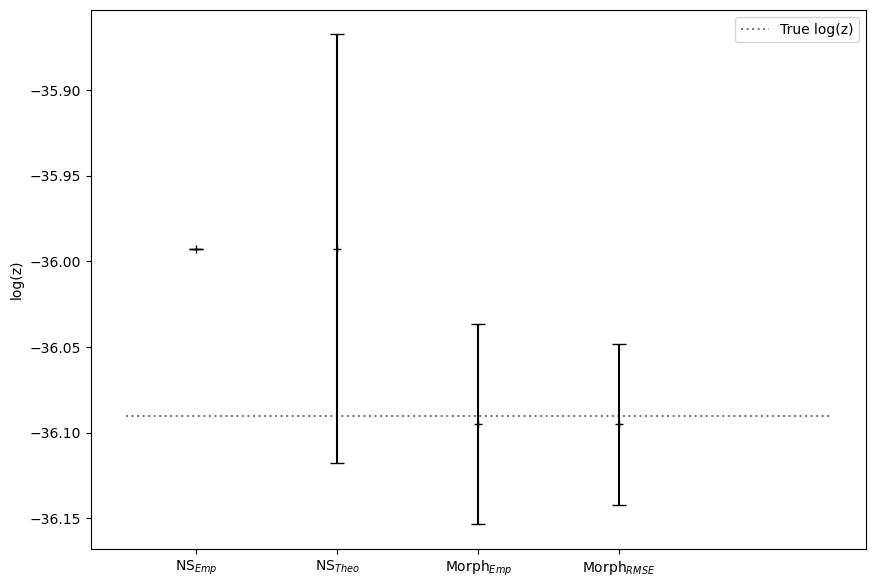

In [10]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

log_p_estimate = np.array(log_p_estimate)

plt.hlines(y=true_logz,colors='grey',linestyle='dotted',xmin=0.5, xmax=5.5,label='True log(z)')

x1= [1,2,3,4]
#median = [np.mean(z_GSS_mcmc),res.logz[-1],np.mean(log_p_estimate)]
#error = [np.std(z_GSS_mcmc),res.logzerr[-1],np.std(log_p_estimate)]
median = [np.mean(log_z_NS),np.mean(log_z_NS),np.mean(log_p_estimate[:,0]),np.mean(log_p_estimate[:,0])]
error = [0,np.mean(log_z_NS_err),np.std(log_p_estimate[:,0]),np.mean(log_p_estimate[:,1])]
ax.errorbar(x1, median, yerr=error, fmt='+', color='black', capsize=5)


ax.set_xticks(x1,labels=[r'NS$_{Emp}$',r'NS$_{Theo}$', r'Morph$_{Emp}$',r'Morph$_{RMSE}$'],fontsize=10)
ax.set_ylabel('log(z)')
ax.legend()